#### Imports

In [1]:
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from imblearn.combine import SMOTETomek
from sklearn.metrics import  f1_score
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import optuna
import joblib

#### Functions

In [5]:
def outlier_thresholds(dataframe ,col , q1=.25, q3=.75, decimal=3):
    quartile1=dataframe[col].quantile(q1)
    quartile3=dataframe[col].quantile(q3)
    iqr=quartile3-quartile1
    low_limit= round(quartile1 - (iqr*1.5) , decimal)
    up_limit= round(quartile3 + (iqr*1.5), decimal)
    return low_limit , up_limit



def replace_with_thresholds(dataframe, col_name, q1=.25, q3=.75, lower_limit=None, upper_limit=None):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)

    if lower_limit is not None:
        low_limit = lower_limit  
    if upper_limit is not None:
        up_limit = upper_limit  

    dataframe.loc[dataframe[col_name] < low_limit, col_name] = low_limit
    dataframe.loc[dataframe[col_name] > up_limit, col_name] = up_limit



def load_customer_data(csv_path="../data/customer_data.csv"):
    import pandas as pd
    return pd.read_csv(csv_path, parse_dates=["birth_date","joined_ING_date"]) 



def load_loan_delinquencies(csv_path="../data/loan_deliquencies.csv"):
    import pandas as pd
    loan_deliquencies = pd.read_csv(csv_path, parse_dates=["start_date","end_date"]) 
    loan_deliquencies["month_difference"] = (
        (loan_deliquencies["end_date"].dt.year - loan_deliquencies["start_date"].dt.year) * 12
        + (loan_deliquencies["end_date"].dt.month - loan_deliquencies["start_date"].dt.month)
    )
    return loan_deliquencies



def load_customer_financials(csv_path="../data/customer_financials.csv"):
    import pandas as pd
    customer_financials = pd.read_csv(csv_path)['cust_id;date;salary;current_acc_balance;saving_acc_balance;credit_card_balance'].str.split(";", expand=True)
    customer_financials.columns = ['cust_id', 'date','salary', 'current_acc_balance','saving_acc_balance', 'credit_card_balance']
    customer_financials['cust_id'] = customer_financials['cust_id'].astype(int)
    customer_financials['date'] = pd.to_datetime(customer_financials['date'], format='%Y-%m-%d')
    for col in ['salary', 'current_acc_balance', 'saving_acc_balance', 'credit_card_balance']:
        customer_financials[col] = pd.to_numeric(customer_financials[col], errors='coerce')   
    return customer_financials



def load_loan_data(csv_path="../data/loan_data.csv"):
    import pandas as pd
    return pd.read_csv(csv_path, parse_dates=["date"])



def preprocess(loan_data_path="../data/loan_data.csv", 
               customer_financials_path="../data/customer_financials.csv", 
               loan_delinquencies_path="../data/loan_deliquencies.csv",
               customer_data_path="../data/customer_data.csv"):
    """
    Preprocesses loan data by merging relevant datasets,
    creating a target variable (default), and dropping unnecessary columns.

    Args:
        loan_data_path (str): Path to the loan data CSV file.
        customer_financials_path (str): Path to the customer financials CSV file.
        loan_delinquencies_path (str): Path to the loan delinquencies CSV file.
        customer_data_path (str): Path to the customer data CSV file.

    Returns:
        pd.DataFrame: Processed loan data.
    """

    customer_data = load_customer_data(customer_data_path)
    loan_delinquencies = load_loan_delinquencies(loan_delinquencies_path)
    customer_financials = load_customer_financials(customer_financials_path)
    loan_data = load_loan_data(loan_data_path)
    loan_data = loan_data.merge(customer_data, on="cust_id", how="left")
    loan_data = loan_data.merge(loan_delinquencies[["loan_id", "month_difference"]], on="loan_id", how="left")
    loan_data[['month_difference']] = loan_data[['month_difference']].fillna(0)
    loan_data['default'] = (loan_data['month_difference'] > 0).astype(int)
    loan_data.drop(columns=['month_difference'], inplace=True)
    loan_data = loan_data.merge(customer_financials, on=["cust_id","date"], how="left")
    loan_data.drop(columns=['number_client_calls_to_ING', 'number_client_calls_from_ING'], inplace=True)
    return loan_data



def add_features(loan_data, customer_financials):

    """
    Adds engineered features to the loan data, including statistical summaries 
    (mean, min, max, std, median) of customer financial data, customer age, 
    tenure, and various ratios based on installment amounts and account balances.

    Args:
        loan_data (pd.DataFrame): The loan data containing customer and loan details.
        customer_financials (pd.DataFrame): The customer financial data for generating features.

    Returns:
        pd.DataFrame: The loan data with added features.
    """

    import pandas as pd
    import numpy as np
    loan_data['salary_mean'] = 0.0
    loan_data['current_acc_balance_mean'] = 0.0
    loan_data['saving_acc_balance_mean'] = 0.0
    loan_data['credit_card_balance_mean'] = 0.0

    loan_data['salary_min'] = 0.0
    loan_data['current_acc_balance_min'] = 0.0
    loan_data['saving_acc_balance_min'] = 0.0
    loan_data['credit_card_balance_min'] = 0.0

    loan_data['salary_max'] = 0.0
    loan_data['current_acc_balance_max'] = 0.0
    loan_data['saving_acc_balance_max'] = 0.0
    loan_data['credit_card_balance_max'] = 0.0

    loan_data['salary_std'] = 0.0
    loan_data['current_acc_balance_std'] = 0.0
    loan_data['saving_acc_balance_std'] = 0.0
    loan_data['credit_card_balance_std'] = 0.0

    loan_data['salary_median'] = 0.0
    loan_data['current_acc_balance_median'] = 0.0
    loan_data['saving_acc_balance_median'] = 0.0
    loan_data['credit_card_balance_median'] = 0.0


    for idx, row in loan_data.iterrows():
        cust_id = row['cust_id']
        current_date = row['date']

        # Summary statistics
        summary = customer_financials[
            (customer_financials.cust_id == cust_id) & 
            (customer_financials.date <= current_date)
        ].describe()

        mean_stats = summary[summary.index == "mean"]
        min_stats = summary[summary.index == "min"]
        max_stats = summary[summary.index == "max"]
        std_stats = summary[summary.index == "std"]
        median_stats = summary[summary.index == "50%"]

        # Mean values
        loan_data.loc[idx, 'salary_mean'] = mean_stats['salary'].values[0]
        loan_data.loc[idx, 'current_acc_balance_mean'] = mean_stats['current_acc_balance'].values[0]
        loan_data.loc[idx, 'saving_acc_balance_mean'] = mean_stats['saving_acc_balance'].values[0]
        loan_data.loc[idx, 'credit_card_balance_mean'] = mean_stats['credit_card_balance'].values[0]

        # Min values
        loan_data.loc[idx, 'salary_min'] = min_stats['salary'].values[0]
        loan_data.loc[idx, 'current_acc_balance_min'] = min_stats['current_acc_balance'].values[0]
        loan_data.loc[idx, 'saving_acc_balance_min'] = min_stats['saving_acc_balance'].values[0]
        loan_data.loc[idx, 'credit_card_balance_min'] = min_stats['credit_card_balance'].values[0]

        # Max values
        loan_data.loc[idx, 'salary_max'] = max_stats['salary'].values[0]
        loan_data.loc[idx, 'current_acc_balance_max'] = max_stats['current_acc_balance'].values[0]
        loan_data.loc[idx, 'saving_acc_balance_max'] = max_stats['saving_acc_balance'].values[0]
        loan_data.loc[idx, 'credit_card_balance_max'] = max_stats['credit_card_balance'].values[0]

        # Std values
        loan_data.loc[idx, 'salary_std'] = std_stats['salary'].values[0]
        loan_data.loc[idx, 'current_acc_balance_std'] = std_stats['current_acc_balance'].values[0]
        loan_data.loc[idx, 'saving_acc_balance_std'] = std_stats['saving_acc_balance'].values[0]
        loan_data.loc[idx, 'credit_card_balance_std'] = std_stats['credit_card_balance'].values[0]

        # Median values
        loan_data.loc[idx, 'salary_median'] = median_stats['salary'].values[0]
        loan_data.loc[idx, 'current_acc_balance_median'] = median_stats['current_acc_balance'].values[0]
        loan_data.loc[idx, 'saving_acc_balance_median'] = median_stats['saving_acc_balance'].values[0]
        loan_data.loc[idx, 'credit_card_balance_median'] = median_stats['credit_card_balance'].values[0]  

    loan_data['age'] = (loan_data['date'] - loan_data['birth_date']).dt.days // 365
    loan_data["tenure"] = ((loan_data['date'].dt.year - loan_data['joined_ING_date'].dt.year) * 12) + (loan_data['date'].dt.month - loan_data['joined_ING_date'].dt.month)
    loan_data['install_salary_ratio'] = loan_data['installment']/loan_data['salary']
    loan_data['install_salary_std'] = loan_data['installment']/loan_data['salary_std']
    loan_data['install_current_acc_std'] = loan_data['installment']/loan_data['current_acc_balance_std']
    loan_data['install_saving_acc_std'] = loan_data['installment']/loan_data['saving_acc_balance_std']
    loan_data['install_credit_card_balance_std'] = loan_data['installment']/loan_data['credit_card_balance_std']
    loan_data['request_segment'] = pd.qcut(loan_data['requested_amount'], 3, labels=[0, 1, 2], duplicates='drop').astype(int)
    loan_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    loan_data.drop(columns=['date','birth_date', 'joined_ING_date', 'loan_id', 'cust_id'], inplace=True)  
    return loan_data



def handle_outliers(loan_data):

    """
    Handles outliers in numerical columns of the loan data by applying quantile-based 
    thresholding (10th and 90th percentiles) separately for loans with default (1) and 
    no default (0), then reassembles the dataset.

    Args:
        loan_data (pd.DataFrame): The loan data containing customer and loan details.

    Returns:
        pd.DataFrame: The loan data with outliers handled.
    """

    num_cols = [col for col in loan_data.columns if loan_data[col].dtype not in ['object', 'datetime64[ns]'] and col not in ['loan_id','cust_id','loan_reason', 'month_difference', 'gender', 'religion', 'employment', 'postal_code','default', 'number_client_calls_to_ING', 'number_client_calls_from_ING']]
    x_1 = loan_data[loan_data.default == 1].drop(columns=['default'])
    x_0 = loan_data[loan_data.default == 0].drop(columns=['default'])
    for col in num_cols:
        replace_with_thresholds(x_1, col, q1=0.1, q3=0.9)
        replace_with_thresholds(x_0, col, q1=0.1, q3=0.9)
    x_1['default'] = 1
    x_0['default'] = 0
    loan_data = pd.concat([x_1, x_0], axis=0)
    del x_1, x_0
    loan_data = shuffle(loan_data, random_state=42)
    return loan_data


def one_hot_encode(loan_data):
    import pandas as pd
    return pd.get_dummies(loan_data, columns=['loan_reason', 'gender', 'religion', 'employment', 'postal_code'])


def test_split(loan_data):

    """
    Splits the loan data into training and testing sets, applying one-hot encoding 
    and computing class weights for imbalanced classes. The split is stratified 
    based on the target variable (default).

    Args:
        loan_data (pd.DataFrame): The loan data containing customer and loan details.

    Returns:
        tuple: A tuple containing the training features (x_train), test features (x_test), 
               and a dictionary of class weights for handling imbalanced classes.
    """

    from sklearn.utils.class_weight import compute_class_weight
    from sklearn.model_selection import train_test_split
    import numpy as np

    loan_data = one_hot_encode(loan_data)
    x = loan_data.drop(columns=['default'])
    y = loan_data['default']  
    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights = dict(zip(classes, weights))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.025, shuffle=True, stratify=y, random_state=42)
    x_train['default'] = y_train
    x_test['default'] = y_test
    return x_train, x_test, class_weights



def knn_imputer(x_train, x_test):

    """
    Scales the training and test data using MinMaxScaler, imputes missing values 
    using KNN imputation, and adds a feature indicating zero or negative balances 
    in key financial accounts. The function also handles stratification of the data 
    based on the 'default' class.

    Args:
        x_train (pd.DataFrame): The training features, including the 'default' column.
        x_test (pd.DataFrame): The test features, including the 'default' column.

    Returns:
        tuple: A tuple containing the imputed and scaled training features (x), 
               test features (x_test), training labels (y), and test labels (y_test).
    """

    from sklearn.preprocessing import MinMaxScaler
    from sklearn.impute import KNNImputer
    from sklearn.utils import shuffle
    import pandas as pd
    
    # MinMax Scaling
    x_1 = x_train[x_train.default == 1].drop(columns=['default'])
    x_0 = x_train[x_train.default == 0].drop(columns=['default'])
    scaler_1 = MinMaxScaler()
    scaler_0 = MinMaxScaler()
    x_1 = pd.DataFrame(scaler_1.fit_transform(x_1), columns=x_1.columns)
    x_0 = pd.DataFrame(scaler_0.fit_transform(x_0), columns=x_0.columns)

    # Imputing
    imputer = KNNImputer(n_neighbors=10)
    x_1 = pd.DataFrame(imputer.fit_transform(x_1), columns=x_1.columns)
    x_0 = pd.DataFrame(imputer.fit_transform(x_0), columns=x_0.columns)
    x_1 = pd.DataFrame(scaler_1.inverse_transform(x_1), columns=x_1.columns)
    x_0 = pd.DataFrame(scaler_0.inverse_transform(x_0), columns=x_0.columns)
    x_1['default'] = 1
    x_0['default'] = 0
    x = pd.concat([x_1, x_0], axis=0)
    del x_1, x_0
    x = shuffle(x, random_state=42)
    y = x['default']  
    x = x.drop(columns=['default'])
    y_test = x_test['default']
    x_test = x_test.drop(columns=['default'])
    scaler = MinMaxScaler().fit(x) 
    imputer.fit(x)
    x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(scaler.inverse_transform(x_test), columns=x_test.columns)

    # Extra feauture
    x['zero_account'] = ((x['credit_card_balance_min'] <= 0) | (x['saving_acc_balance_min'] <= 0) | (x['current_acc_balance_min'] <= 0) | (x['salary_min'] <= 0)).astype(int)
    x_test['zero_account'] = ((x_test['credit_card_balance_min'] <= 0) | (x_test['saving_acc_balance_min'] <= 0) | (x_test['current_acc_balance_min'] <= 0) | (x_test['salary_min'] <= 0)).astype(int)
    
    # Reset Indices
    x.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    return x, x_test, y, y_test


def valid_split(x, y):
    from sklearn.model_selection import train_test_split
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    x_valid.reset_index(drop=True, inplace=True)
    y_valid.reset_index(drop=True, inplace=True)
    return x_train, x_valid, y_train, y_valid



def train_valid_test(loan_data_path="../data/loan_data.csv", 
                    customer_financials_path="../data/customer_financials.csv", 
                    loan_delinquencies_path="../data/loan_deliquencies.csv",
                    customer_data_path="../data/customer_data.csv",
                    selected_features=None):
    
    """
    Preprocesses loan data, adds features, handles outliers, and splits the data 
    into training, validation, and test sets. It also applies KNN imputation and 
    scaling. Optionally, selected features can be used for model training.

    Args:
        loan_data_path (str): Path to the loan data CSV file.
        customer_financials_path (str): Path to the customer financials CSV file.
        loan_delinquencies_path (str): Path to the loan delinquencies CSV file.
        customer_data_path (str): Path to the customer data CSV file.
        selected_features (list, optional): List of features to use for model training.

    Returns:
        tuple: A tuple containing the training, validation, and test sets (x_train, x_valid, x_test),
               as well as the corresponding labels (y_train, y_valid, y_test) and class weights.
    """    

    import warnings
    warnings.filterwarnings('ignore')
    df = preprocess(loan_data_path, customer_financials_path,
               loan_delinquencies_path, customer_data_path)
    customer_financials = load_customer_financials(customer_financials_path)
    df = add_features(df, customer_financials)
    df = handle_outliers(df)
    train, test, class_weights = test_split(df)
    x_train, x_test, y_train, y_test = knn_imputer(train,test)
    x_train, x_valid, y_train, y_valid = valid_split(x_train, y_train)
    if selected_features is not None:
        x_train = x_train[selected_features]
        x_valid = x_valid[selected_features]
        x_test = x_test[selected_features]
    return x_train, x_valid, x_test, y_train, y_valid, y_test, class_weights



def find_best_model(x_train, x_valid, y_train, y_valid, class_weights):

    """
    Trains and evaluates multiple machine learning models (LightGBM, CatBoost, XGBoost, and RandomForest) 
    on the provided training and validation data. The models are evaluated based on recall, precision, 
    F1 score, and accuracy. The results are returned in a sorted dataframe by F1 score.

    Args:
        x_train (pd.DataFrame): The features of the training set.
        x_valid (pd.DataFrame): The features of the validation set.
        y_train (pd.Series): The target labels of the training set.
        y_valid (pd.Series): The target labels of the validation set.
        class_weights (dict): The class weights to handle imbalanced classes.

    Returns:
        pd.DataFrame: A dataframe containing the evaluation scores for each model, sorted by F1 score.
    """

    from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
    from sklearn.ensemble import RandomForestClassifier
    from lightgbm import LGBMClassifier
    from catboost import CatBoostClassifier
    from xgboost import XGBClassifier
    import pandas as pd
    
    # LightGBM Model
    lgb_model = LGBMClassifier(random_state=17, verbose=-1, class_weight=class_weights)
    lgb_model.fit(x_train, y_train)
    y_pred = lgb_model.predict(x_valid)
    lgb_recall = recall_score(y_valid, y_pred)
    lgb_precision = precision_score(y_valid, y_pred)
    lgb_f1 = f1_score(y_valid, y_pred)
    lgb_accuracy = accuracy_score(y_valid, y_pred)
    lgb_scores = [(lgb_recall, lgb_precision, lgb_f1, lgb_accuracy)]
    lgb_scores = pd.DataFrame(data=lgb_scores, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    lgb_scores.insert(0, 'Model', ['LightGBM'])

    # CatBoost Model
    cat_model = CatBoostClassifier(random_state=17, verbose=False, class_weights=class_weights)
    cat_model.fit(x_train, y_train)
    y_pred = cat_model.predict(x_valid)
    cat_recall = recall_score(y_valid, y_pred)
    cat_precision = precision_score(y_valid, y_pred)
    cat_f1 = f1_score(y_valid, y_pred)
    cat_accuracy = accuracy_score(y_valid, y_pred)
    cat_scores = [(cat_recall, cat_precision, cat_f1, cat_accuracy)]
    cat_scores = pd.DataFrame(data=cat_scores, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    cat_scores.insert(0, 'Model', ['CatBoost'])

    # XGBoost Model
    xgb_model = XGBClassifier(random_state=17, class_weights=class_weights)
    xgb_model.fit(x_train, y_train)
    y_pred = xgb_model.predict(x_valid)
    xgb_recall = recall_score(y_valid, y_pred)
    xgb_precision = precision_score(y_valid, y_pred)
    xgb_f1 = f1_score(y_valid, y_pred)
    xgb_accuracy = accuracy_score(y_valid, y_pred)
    xgb_scores = [(xgb_recall, xgb_precision, xgb_f1, xgb_accuracy)]
    xgb_scores = pd.DataFrame(data=xgb_scores, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    xgb_scores.insert(0, 'Model', ['XGBoost'])

    # Random Forest Model
    rf = RandomForestClassifier(random_state=17, max_depth=1000, n_jobs=-1, class_weight=class_weights)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_valid)
    rf_recall = recall_score(y_valid, y_pred)
    rf_precision = precision_score(y_valid, y_pred)
    rf_f1 = f1_score(y_valid, y_pred)
    rf_accuracy = accuracy_score(y_valid, y_pred)
    rf_scores = [(rf_recall, rf_precision, rf_f1, rf_accuracy)]
    rf_scores = pd.DataFrame(data=rf_scores, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    rf_scores.insert(0, 'Model', ['RandomForest'])  
      
    score_board = pd.concat([lgb_scores, cat_scores, xgb_scores, rf_scores], ignore_index=True)
    return score_board.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)




def find_best_sampling(x_train, x_valid, y_train, y_valid, class_weights):
    
    """
    Trains a CatBoost classifier using various sampling techniques (no sampling, random oversampling, 
    random undersampling, SMOTE, TomekLinks, SMOTETomek, and SMOTEENN) on the provided training data, 
    and evaluates model performance on the validation set. The evaluation metrics include recall, precision, 
    F1 score, and accuracy. The results are returned in a dataframe, sorted by F1 score.

    Args:
        x_train (pd.DataFrame): The features of the training set.
        x_valid (pd.DataFrame): The features of the validation set.
        y_train (pd.Series): The target labels of the training set.
        y_valid (pd.Series): The target labels of the validation set.
        class_weights (dict): The class weights to handle imbalanced classes.

    Returns:
        pd.DataFrame: A dataframe containing the evaluation scores for each sampling technique, sorted by F1 score.
    """
    
    from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
    from imblearn.under_sampling import RandomUnderSampler, TomekLinks
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    from imblearn.combine import SMOTETomek, SMOTEENN
    from catboost import CatBoostClassifier
    import pandas as pd
    cat_model = CatBoostClassifier(random_state=2, verbose=False, class_weights=class_weights)

    # No Sampling
    cat_model.fit(x_train, y_train)
    y_pred = cat_model.predict(x_valid)
    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    scores_01 = [(recall, precision, f1, accuracy)]
    scores_01 = pd.DataFrame(data=scores_01, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    scores_01.insert(0, 'Sampling', ['None'])

    # Random Over Sampling
    ros = RandomOverSampler(random_state=42)
    x_over, y_over = ros.fit_resample(x_train, y_train)
    cat_model.fit(x_over, y_over)
    y_pred = cat_model.predict(x_valid)
    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    scores_02 = [(recall, precision, f1, accuracy)]
    scores_02 = pd.DataFrame(data=scores_02, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    scores_02.insert(0, 'Sampling', ['Random Oversampling'])

    # Random Under Sampling
    rus = RandomUnderSampler(random_state=42)
    x_under, y_under = rus.fit_resample(x_train, y_train)
    cat_model.fit(x_under, y_under)
    y_pred = cat_model.predict(x_valid)
    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    scores_03 = [(recall, precision, f1, accuracy)]
    scores_03 = pd.DataFrame(data=scores_03, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    scores_03.insert(0, 'Sampling', ['Random Undersampling'])

    # SMOTE
    x_smote, y_smote = SMOTE(random_state=42).fit_resample(x_train, y_train)
    cat_model.fit(x_smote, y_smote)
    y_pred = cat_model.predict(x_valid)
    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    scores_04 = [(recall, precision, f1, accuracy)]
    scores_04 = pd.DataFrame(data=scores_04, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    scores_04.insert(0, 'Sampling', ['SMOTE'])

    # TomekLinks Undersampling
    utomek = TomekLinks(sampling_strategy='auto', n_jobs=-1)
    x_utomek, y_utomek = utomek.fit_resample(x_train, y_train)
    cat_model.fit(x_utomek, y_utomek)
    y_pred = cat_model.predict(x_valid)
    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    scores_05 = [(recall, precision, f1, accuracy)]
    scores_05 = pd.DataFrame(data=scores_05, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    scores_05.insert(0, 'Sampling', ['TomekLinks Undersampling'])

    # SMOTETomek
    x_stomek, y_stomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=2).fit_resample(x_train, y_train)
    cat_model.fit(x_stomek, y_stomek)
    y_pred = cat_model.predict(x_valid)
    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    scores_06 = [(recall, precision, f1, accuracy)]
    scores_06 = pd.DataFrame(data=scores_06, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    scores_06.insert(0, 'Sampling', ['SMOTETomek'])

    # SMOTEENN
    x_smoten, y_smoten = SMOTEENN(random_state=42).fit_resample(x_train, y_train)
    cat_model.fit(x_smoten, y_smoten)
    y_pred = cat_model.predict(x_valid)
    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    scores_07 = [(recall, precision, f1, accuracy)]
    scores_07 = pd.DataFrame(data=scores_07, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
    scores_07.insert(0, 'Sampling', ['SMOTEENN'])

    score_board = pd.concat([scores_07, scores_06, scores_05, scores_04, scores_03, scores_02, scores_01], ignore_index=True)
    return score_board.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)



def find_num_features(x_smotet, x_valid, y_smotet, y_valid, class_weights):

    """
    Selects the best number of features using mutual information and evaluates the performance of a CatBoost 
    classifier for each number of features on the validation set. The F1 score (weighted) is computed for each 
    iteration, and a bar plot is generated showing the F1 score against the number of selected features.

    Args:
        x_smotet (pd.DataFrame): The features of the training set after SMOTETomek.
        x_valid (pd.DataFrame): The features of the validation set.
        y_smotet (pd.Series): The target labels of the training set after SMOTETomek.
        y_valid (pd.Series): The target labels of the validation set.
        class_weights (dict): The class weights to handle imbalanced classes.

    Returns:
        None: The function generates a bar plot showing the F1 score for different numbers of selected features.
    """

    from sklearn.feature_selection import mutual_info_classif
    from sklearn.feature_selection import SelectKBest
    from matplotlib.ticker import MaxNLocator
    from catboost import CatBoostClassifier
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    import numpy as np

    f1_score_list = []
    cat_model = CatBoostClassifier(random_state=17, verbose=False, class_weights=class_weights)
    for k in range(1, 62):
        #print(f'{k}. iteration has started...')
        selector = SelectKBest(mutual_info_classif, k=k)
        selector.fit(x_smotet, y_smotet)
        
        sel_x_train = selector.transform(x_smotet)
        sel_x_valid = selector.transform(x_valid)
        
        cat_model.fit(sel_x_train, y_smotet)
        kbest_preds = cat_model.predict(sel_x_valid)
        
        f1_score_kbest = round(f1_score(y_valid, kbest_preds, average='weighted'), 3)
        f1_score_list.append(f1_score_kbest)


    _, ax = plt.subplots(figsize=(16, 8)) 
    ax.bar(np.arange(1, 62), f1_score_list, width=0.4)
    ax.set_xlabel('Number of features selected using mutual information', fontsize=14)
    ax.set_ylabel('F1-Score (weighted)', fontsize=14)
    ax.set_ylim(0, 1) 
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  

    for i, v in enumerate(f1_score_list):
        plt.text(x=i + 1, y=v + 0.05, s=f'{v:.2f}', ha='center', fontsize=8, rotation=45)

    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()



def find_best_features(x_smotet, y_smotet, class_weights, num_features=50):

    """
    Selects the best features using Recursive Feature Elimination (RFE) with a CatBoost classifier. 
    The function selects the specified number of features (default is 50) based on their importance 
    for predicting the target variable.

    Args:
        x_smotet (pd.DataFrame): The features of the training set after SMOTETomek.
        y_smotet (pd.Series): The target labels of the training set after SMOTETomek.
        class_weights (dict): The class weights to handle imbalanced classes.
        num_features (int, optional): The number of features to select (default is 50).

    Returns:
        selected_features (Index): The names of the selected features.
    """

    from sklearn.feature_selection import RFE
    from catboost import CatBoostClassifier
    cat_model = CatBoostClassifier(random_state=17, verbose=False, class_weights=class_weights)
    RFE_selector = RFE(estimator=cat_model, n_features_to_select=num_features, step=1)
    RFE_selector.fit(x_smotet, y_smotet)
    selected_features_mask = RFE_selector.get_support()
    selected_features = x_smotet.columns[selected_features_mask]
    return selected_features



def model_performance(cat_model, x_train, x_valid, x_test, y_train, y_valid, y_test):

    """
    Evaluates the performance of a trained model on training, validation, and test datasets using 
    multiple classification metrics (Recall, Precision, F1 Score, Accuracy, ROC AUC).

    Args:
        cat_model (sklearn or CatBoost model): The trained classifier model.
        x_train (pd.DataFrame): Features of the training dataset.
        x_valid (pd.DataFrame): Features of the validation dataset.
        x_test (pd.DataFrame): Features of the test dataset.
        y_train (pd.Series): Target labels of the training dataset.
        y_valid (pd.Series): Target labels of the validation dataset.
        y_test (pd.Series): Target labels of the test dataset.

    Returns:
        pd.DataFrame: A dataframe containing performance metrics (Recall, Precision, F1 Score, Accuracy, ROC AUC) 
                      for each dataset (Train, Validation, Test) sorted by F1 Score.
    """

    from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score
    import pandas as pd
    
    # Train performance
    y_pred = cat_model.predict(x_train)
    y_pred_prob = cat_model.predict_proba(x_train)[:, 1]
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    roc_auc = roc_auc_score(y_train, y_pred_prob)
    scores_01 = [(recall, precision, f1, accuracy, roc_auc)]
    scores_01 = pd.DataFrame(data=scores_01, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy', 'ROC AUC'])
    scores_01.insert(0, 'Dataset', ['Train'])

    # Validation performance
    y_pred = cat_model.predict(x_valid)
    y_pred_prob = cat_model.predict_proba(x_valid)[:, 1]
    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred_prob)
    scores_02 = [(recall, precision, f1, accuracy, roc_auc)]
    scores_02 = pd.DataFrame(data=scores_02, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy', 'ROC AUC'])
    scores_02.insert(0, 'Dataset', ['Validation'])

    # Test performance
    y_pred = cat_model.predict(x_test)
    y_pred_prob = cat_model.predict_proba(x_test)[:, 1]
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    scores_03 = [(recall, precision, f1, accuracy, roc_auc)]
    scores_03 = pd.DataFrame(data=scores_03, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy', 'ROC AUC'])
    scores_03.insert(0, 'Dataset', ['Test'])

    score_board = pd.concat([scores_03, scores_02, scores_01], ignore_index=True)
    return score_board.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)



def objective(trial):

    param = {
        
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0), 
        "random_strength": trial.suggest_float("random_strength", 1.0, 10.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param, class_weights=class_weights, random_state=2, thread_count=-1)
    gbm.fit(x_smotet, y_smotet, eval_set=[(x_valid, y_valid)], verbose=0, early_stopping_rounds=100)
    preds = gbm.predict(x_valid)
    pred_labels = np.rint(preds)
    f1 = f1_score(y_valid, pred_labels)

    return f1


def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", 0)
    if frozen_trial.number % 20 == 0:
        print(f"Trial {frozen_trial.number} has started.")
    #print(f"Trial {frozen_trial.number} has started.")  
    if study.best_value > previous_best_value: 
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )
    study.set_user_attr("previous_best_value", study.best_value)


def cluster_analysis(x_train, y_train):

    """
    Performs dimensionality reduction on the training data using t-SNE, PCA, and Truncated SVD, 
    and visualizes the clusters (No Delinquent vs Delinquent) in 2D space.

    Args:
        x_train (pd.DataFrame): Features of the training dataset.
        y_train (pd.Series): Target labels (0 for No Delinquent, 1 for Delinquent) of the training dataset.

    Returns:
        None: Displays scatter plots of the data after dimensionality reduction using t-SNE, PCA, and Truncated SVD.
    """

    from sklearn.decomposition import PCA, TruncatedSVD
    from sklearn.preprocessing import RobustScaler
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    
    scaler = RobustScaler()
    x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)

    x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x_train.values)
    x_pca = PCA(n_components=2, random_state=42).fit_transform(x_train.values)
    x_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(x_train.values)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
    f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


    blue_patch = mpatches.Patch(color='#0A0AFF', label='No Delinquent')
    red_patch = mpatches.Patch(color='#AF0000', label='Delinquent')


    # t-SNE scatter plot
    ax1.scatter(x_tsne[:,0], x_tsne[:,1], c=(y_train == 0), cmap='coolwarm', label='No Delinquent', linewidths=2)
    ax1.scatter(x_tsne[:,0], x_tsne[:,1], c=(y_train == 1), cmap='coolwarm', label='Delinquent', linewidths=2)
    ax1.set_title('t-SNE', fontsize=14)

    ax1.grid(True)
    ax1.legend(handles=[blue_patch, red_patch])


    # PCA scatter plot
    ax2.scatter(x_pca[:,0], x_pca[:,1], c=(y_train == 0), cmap='coolwarm', label='No Delinquent', linewidths=2)
    ax2.scatter(x_pca[:,0], x_pca[:,1], c=(y_train == 1), cmap='coolwarm', label='Delinquent', linewidths=2)
    ax2.set_title('PCA', fontsize=14)

    ax2.grid(True)
    ax2.legend(handles=[blue_patch, red_patch])

    # TruncatedSVD scatter plot
    ax3.scatter(x_svd[:,0], x_svd[:,1], c=(y_train == 0), cmap='coolwarm', label='No Delinquent', linewidths=2)
    ax3.scatter(x_svd[:,0], x_svd[:,1], c=(y_train == 1), cmap='coolwarm', label='Delinquent', linewidths=2)
    ax3.set_title('Truncated SVD', fontsize=14)

    ax3.grid(True)
    ax3.legend(handles=[blue_patch, red_patch])

    plt.show()




def calibrate_model(x_train, y_train, x_valid, y_valid, class_weights, method = "sigmoid", return_model = False):

    """
    Trains a CatBoost model, calibrates it using the specified method, and evaluates its performance on the validation set.

    Args:
        x_train (pd.DataFrame): Feature data for training.
        y_train (pd.Series): Target labels for training.
        x_valid (pd.DataFrame): Feature data for validation.
        y_valid (pd.Series): Target labels for validation.
        class_weights (dict): Class weights for the model.
        method (str, optional): Calibration method to use ('sigmoid' or 'isotonic'). Default is 'sigmoid'.
        return_model (bool, optional): Whether to return the calibrated model. Default is False.

    Returns:
        CalibratedClassifierCV (optional): The calibrated model if `return_model=True`.
        None: If `return_model=False`. Displays the calibration plot and classification report.
    """

    from sklearn.metrics import classification_report
    from catboost import CatBoostClassifier
    from sklearn import calibration
    import matplotlib.pyplot as plt


    params = {'colsample_bylevel': 0.3, 'depth': 8, 'l2_leaf_reg': 3.4}
    
    # Base Model
    base_model = CatBoostClassifier(**params, random_state=4, verbose=False, class_weights=class_weights)
    base_model.fit(x_train, y_train)
    
    # Base preds
    y_pred_base_prob = base_model.predict_proba(x_valid)[:, 1]
    base_prob_true, base_prob_pred = calibration.calibration_curve(y_valid, y_pred_base_prob, n_bins=10)
    
    # Fit calibration
    base_model = CatBoostClassifier(**params, random_state=4, verbose=False, class_weights=class_weights)
    calib_model = calibration.CalibratedClassifierCV(
        method=method,
        estimator=base_model,
        cv=5
    )
    calib_model.fit(x_train, y_train)
    
    # Calibrated preds
    y_pred = calib_model.predict(x_valid)
    y_pred_prob = calib_model.predict_proba(x_valid)[:,1]
    print(classification_report(y_valid, y_pred))
    
    
    # Calibrated probs
    prob_true, prob_pred = calibration.calibration_curve(y_valid, y_pred_prob, n_bins=10)
    
    # Plot
    plt.plot(prob_pred, prob_true, marker='+', label=f'CatBoost + {method} calibration')
    plt.plot([0,1],[0,1], linestyle='--', label='perfect calibration')
    plt.plot(base_prob_true, base_prob_pred, marker='o', label='not calibrated')
    plt.legend()
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.show()

    if return_model:
        return calib_model

#### Train - Validation - Test Split

In [3]:
# After data preprocessing, feature engineering, outlier replacement, and KNN imputation steps, 
# I split the data into train, validation, and test sets in a stratified manner.
x_train, x_valid, x_test, y_train, y_valid, y_test, class_weights = train_valid_test()

#### Model Selection

In [6]:
# When evaluating the models based on their F1 scores, I decided on the CatBoost model.
find_best_model(x_train, x_valid, y_train, y_valid, class_weights)

,Model,Recall,Precision,F1 Score,Accuracy
0,CatBoost,0.724589,0.679459,0.701299,0.764103
1,LightGBM,0.730292,0.671292,0.699550,0.760256
2,XGBoost,0.595773,0.727869,0.655230,0.760385
3,RandomForest,0.502851,0.743183,0.599840,0.743590


#### Sampling Selection

In [ ]:
# I decided on the SMOTETomek technique.
find_best_sampling(x_train, x_valid, y_train, y_valid, class_weights)

,Sampling,Recall,Precision,F1 Score,Accuracy
0,SMOTETomek,0.759477,0.661215,0.706948,0.759359
1,TomekLinks Undersampling,0.776585,0.644847,0.704611,0.751154
2,SMOTE,0.733646,0.671683,0.701299,0.761154
3,None,0.723583,0.678942,0.700552,0.763590
4,Random Oversampling,0.818182,0.612199,0.700359,0.732436
5,Random Undersampling,0.843006,0.587561,0.692477,0.713846
6,SMOTEENN,0.794029,0.558782,0.655951,0.681667


#### Number of feature selection

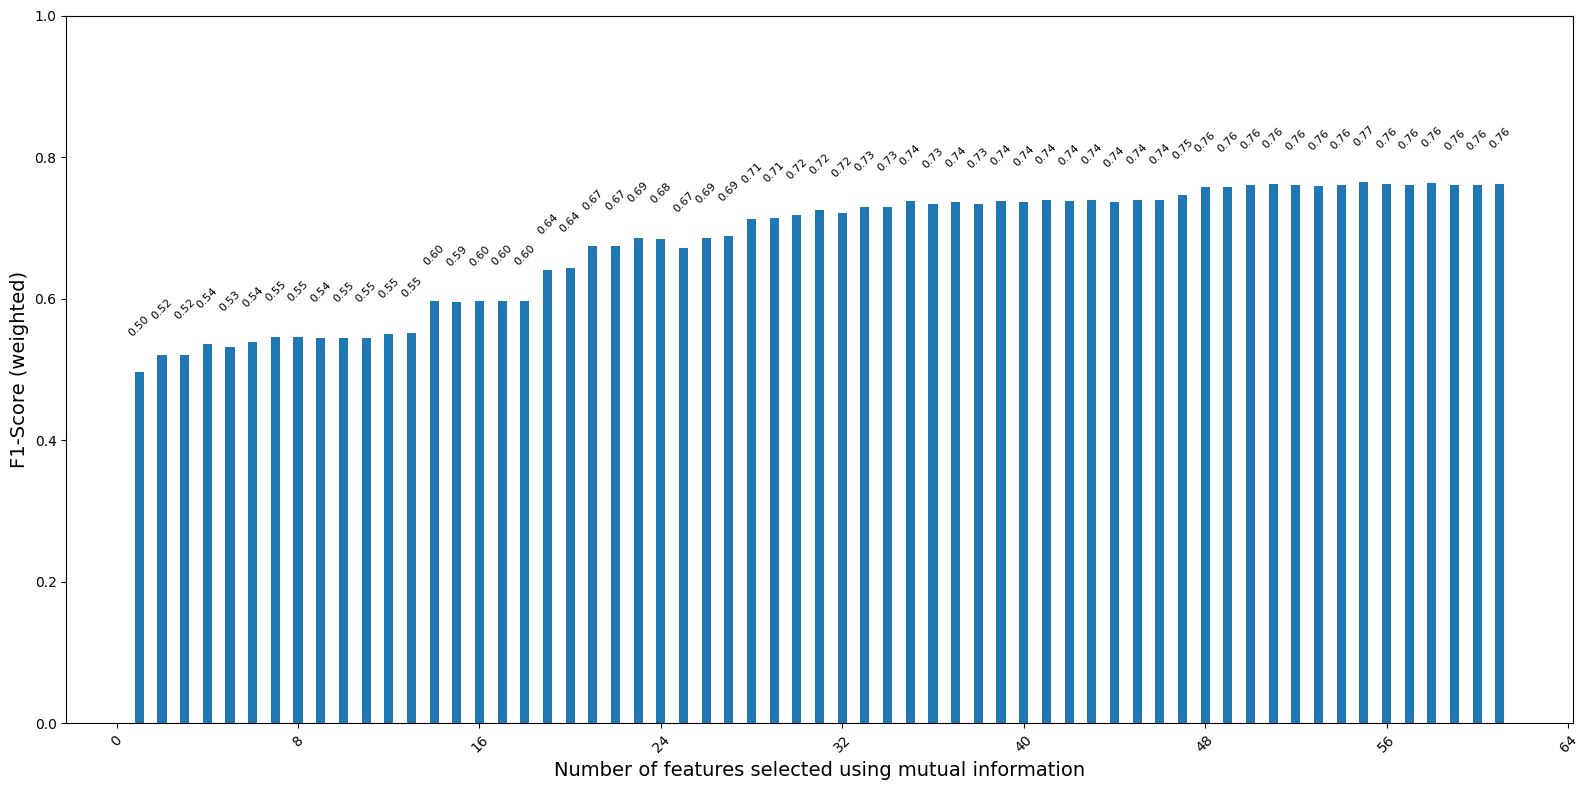

In [ ]:
# Based on the mutual information scores, I evaluated the number of features 
# and decided that approximately 48-50 features would be sufficient.
x_smotet, y_smotet = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=4).fit_resample(x_train, y_train)
find_num_features(x_smotet, x_valid, y_smotet, y_valid, class_weights)

#### Best Features Selection

In [ ]:
# I used the Recursive Feature Elimination (RFE) method to select the best features.
selected_features = find_best_features(x_smotet, y_smotet, class_weights)
selected_features

['loan_term',
 'requested_amount',
 'installment',
 'number_loans_accounts',
 'number_accounts',
 'salary',
 'current_acc_balance',
 'saving_acc_balance',
 'credit_card_balance',
 'age',
 'tenure',
 'saving_acc_balance_mean',
 'credit_card_balance_mean',
 'salary_min',
 'current_acc_balance_min',
 'saving_acc_balance_min',
 'credit_card_balance_min',
 'salary_max',
 'current_acc_balance_max',
 'saving_acc_balance_max',
 'credit_card_balance_max',
 'salary_std',
 'current_acc_balance_std',
 'saving_acc_balance_std',
 'credit_card_balance_std',
 'salary_median',
 'current_acc_balance_median',
 'credit_card_balance_median',
 'install_salary_ratio',
 'install_salary_std',
 'install_current_acc_std',
 'install_saving_acc_std',
 'install_credit_card_balance_std',
 'request_segment',
 'loan_reason_Car',
 'loan_reason_Financial',
 'loan_reason_Housing',
 'loan_reason_Personal',
 'gender_F',
 'gender_M',
 'religion_C',
 'religion_M',
 'religion_U',
 'employment_Private Sector',
 'employment_Pub

selected_features = ['loan_term', 'requested_amount', 'installment', 'number_loans_accounts', 'number_accounts', 'salary', 'current_acc_balance', 'saving_acc_balance', 'credit_card_balance', 'age', 'tenure', 'saving_acc_balance_mean', 'credit_card_balance_mean', 'salary_min', 'current_acc_balance_min', 'saving_acc_balance_min', 'credit_card_balance_min', 'salary_max', 'current_acc_balance_max', 'saving_acc_balance_max', 'credit_card_balance_max', 'salary_std', 'current_acc_balance_std',
       'saving_acc_balance_std', 'credit_card_balance_std', 'salary_median', 'current_acc_balance_median', 'credit_card_balance_median', 'install_salary_ratio', 'install_salary_std', 'install_current_acc_std', 'install_saving_acc_std', 'install_credit_card_balance_std', 'request_segment', 'loan_reason_Car', 'loan_reason_Financial', 'loan_reason_Housing', 'loan_reason_Personal', 'gender_F', 'gender_M', 'religion_C', 'religion_M', 'religion_U', 'employment_Private Sector',
       'employment_Public Sector', 'employment_Unemployed', 'postal_code_10', 'postal_code_20', 'postal_code_30', 'postal_code_50']

#### Hyperparameter Optimization

In [ ]:
# I attempted hyperparameter optimization using Optuna, but it did not result in any significant improvement. 
# Therefore, I tried manually adjusting a few hyperparameters, but I still couldn't achieve any performance gain.

optuna.logging.set_verbosity(optuna.logging.WARN)
study = optuna.create_study(study_name="catboost_params", 
                            direction="maximize", 
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner())


study.optimize(objective, timeout=3600, callbacks=[logging_callback], n_jobs=-1)

#### Final Model Performance

In [207]:
# You can see final model performance below. 
params = {'colsample_bylevel': 0.3, 'depth': 8, 'l2_leaf_reg': 3.4}
cat_model = CatBoostClassifier(**params , random_state=4, verbose=False, class_weights=class_weights).fit(x_smotet[selected_features], y_smotet)
model_performance(cat_model, x_train[selected_features], x_valid[selected_features], x_test[selected_features], y_train, y_valid, y_test)

,Dataset,Recall,Precision,F1 Score,Accuracy,ROC AUC
0,Train,0.906475,0.775029,0.835614,0.863718,0.948381
1,Validation,0.753774,0.658365,0.702846,0.756410,0.846415
2,Test,0.890052,0.455154,0.602303,0.551000,0.684394


#### Cluster Analysis

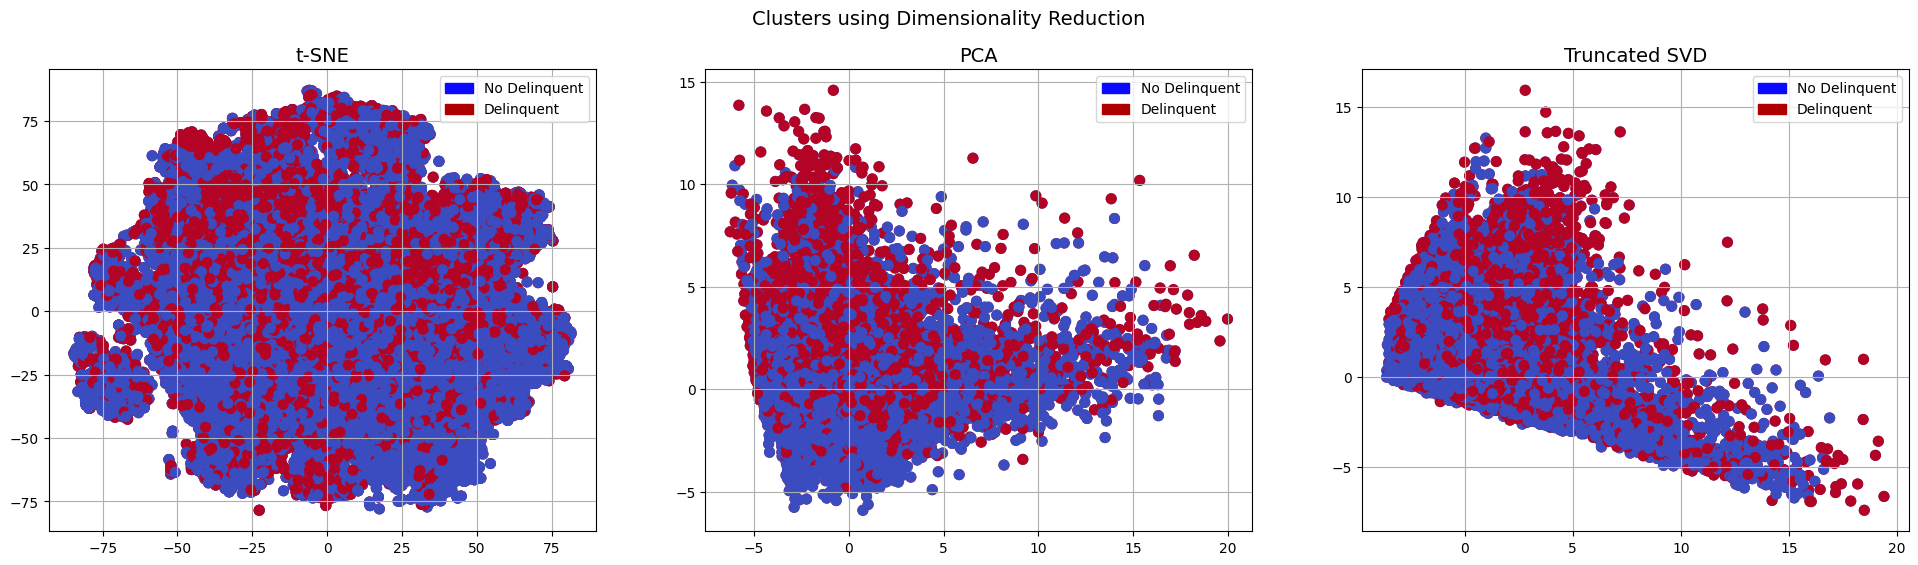

In [ ]:
# In this part, I wanted to check whether the data was well-separated or not by using dimensionality reduction.
cluster_analysis(x_train[selected_features], y_train)

#### Correlation with target

In [193]:
df = x_train[selected_features].copy()
df['default'] = y_train
corr_matrix = df.corr()
corr_matrix['default'].sort_values(ascending=False).head(10)

default                       1.000000
install_saving_acc_std        0.175313
requested_amount              0.152956
installment                   0.134110
request_segment               0.130949
install_salary_ratio          0.124350
credit_card_balance           0.121774
credit_card_balance_min       0.115516
credit_card_balance_mean      0.114873
credit_card_balance_median    0.113895
Name: default, dtype: float64

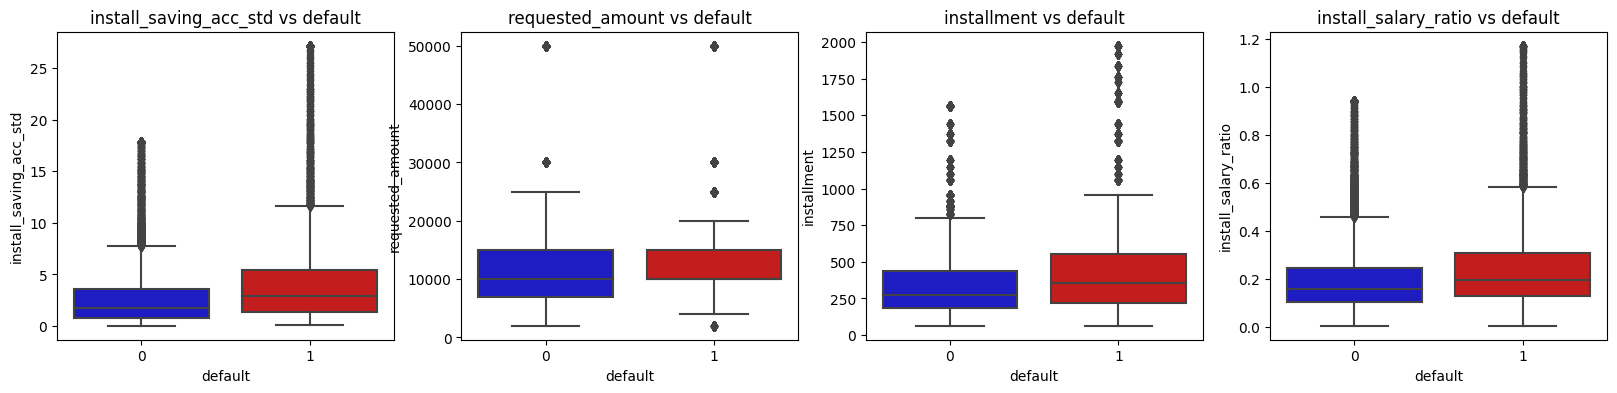

In [ ]:
# Positive correlation with target

f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ["#0101DF", "#DF0101"]
sns.boxplot(x="default", y="install_saving_acc_std", data=df, palette=colors, ax=axes[0])
axes[0].set_title('install_saving_acc_std vs default')

sns.boxplot(x="default", y="requested_amount", data=df, palette=colors, ax=axes[1])
axes[1].set_title('requested_amount vs default')


sns.boxplot(x="default", y="installment", data=df, palette=colors, ax=axes[2])
axes[2].set_title('installment vs default')


sns.boxplot(x="default", y="install_salary_ratio", data=df, palette=colors, ax=axes[3])
axes[3].set_title('install_salary_ratio vs default')

plt.show()

#### Model Calibration

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      4819
           1       0.77      0.60      0.68      2981

    accuracy                           0.78      7800
   macro avg       0.78      0.75      0.75      7800
weighted avg       0.78      0.78      0.77      7800



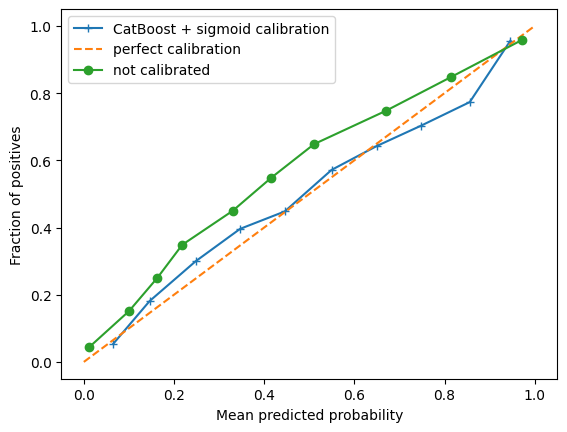

In [9]:
# I calibrated the model to make it easier to interpret.
calib_model = calibrate_model(x_smotet[selected_features], y_smotet, x_valid[selected_features], y_valid, class_weights, method = "sigmoid", return_model = True)

#### Feature Analysis

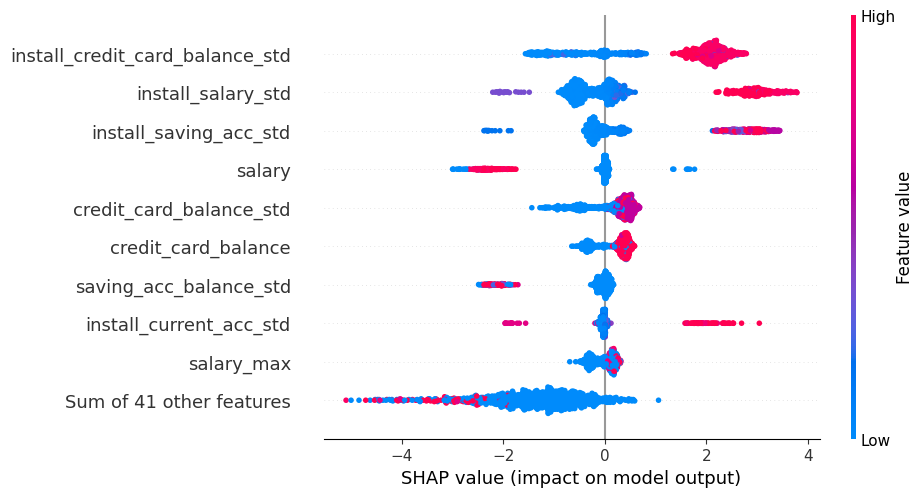

In [ ]:
# Best features
import shap
shap.initjs()
explainer = shap.Explainer(cat_model)
shap_values = explainer(x_test[selected_features])
shap.plots.beeswarm(shap_values, max_display=10)

#### Save

In [ ]:
# I've saved the scaler, imputer, and calibrated model because I will need them while deploying the model with Streamlit.
scaler = MinMaxScaler()
imputer = KNNImputer(n_neighbors=10)
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train[selected_features]), columns=x_train[selected_features].columns)
imputer.fit(x_train_scaled)
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(imputer, 'imputer.joblib')
joblib.dump(calib_model, "calib_model.pkl")

['calib_model.pkl']